In [1]:
# Include project path to available custom class at jupyter
import os
import sys
sys.path.insert(0, os.path.abspath('/home/stacked_ensemble/'))

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import importlib
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gensim

import re
import utils.definition_network as dn

import psycopg2
from sqlalchemy import create_engine

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.similarities.index import AnnoyIndexer
from gensim.scripts.glove2word2vec import glove2word2vec
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from glove import Corpus, Glove
from collections import Counter
import pickle

<p>
<h2>1.0 Analysis of key terms to identify Anxiety and Depression pathologies</h2>
    <ol><b>Steps</b>:
    <li>Load word embeddings used in weak classifiers</li>
    <li>Load texts on description / definition of anxiety and depression pathologies according to the DSM-5 manual</li>
    <li><b>Analyzes terms for Anxiety</b>. Search for the most frequent words for Anxiety in the DSM-V diagnostic descriptions. From this list of the most frequent words, I extracted a subset of those that have greater informational gain, by visual inspection according to experts. Finally, it analyzes its incidence or similarity with those existing in the SMHD Anxiety and SMHD Anxiety, Depression dataset.</li>
    <li><b>Analyzes terms for Depression</b>. Search for more frequent words for Depression in the DSM-V diagnostic descriptions. From the list of most frequent words, I extracted a subset of those that have greater informational gain, by visual inspection in the spreadsheet according to experts. Finally, it analyzes its incidence or similarity with those existing in the SMHD Depression and SMHD Anxiety, Depression dataset.</li>
    </ol>
</p>

### 1.1 Load word embeddings used in weak classifiers

In [3]:
WORD_EMB_FILE_PATH = dn.PATH_PROJECT + 'pre_train_embeddings/'

In [4]:
def convert_glove_pkl_to_txt(file_path_pkl, new_file_name):
    f = open(file_path_pkl, 'rb')
    teste = pickle.load(f, encoding='utf-8')
    f.close()
    
    for i in range(len(teste['inverse_dictionary'])):
        fl = open(new_file_name, 'a+', encoding='utf-8')
        word_vector_values = teste['inverse_dictionary'][i]

        for word_value in teste['word_vectors'][i]:
            word_vector_values = word_vector_values + " " + '{0:.{1}f}'.format(word_value, 5)

        fl.write(word_vector_values + '\n')
        fl.close()    

In [5]:
# Function convert embeddings glove custom from binary to txt
# convert_glove_pkl_to_txt(WORD_EMB_FILE_PATH + 'glove/SMHD-glove-A-D-ADUsers-300.pkl', 
#                          WORD_EMB_FILE_PATH + 'glove/SMHD-glove-A-D-ADUsers-300.txt')

In [6]:
# For glove, convert to word2vec for analyze terms using methods w2v
# glove = glove2word2vec(glove_input_file=WORD_EMB_FILE_PATH + 'glove.6B/glove.6B.300d.txt', 
#                        word2vec_output_file=dn.PATH_PROJECT + '/pre_train_embeddings/gensim_glove.6B.300d.txt')

In [7]:
# Load Word embeddings usada nos submodels CA1..2, CD1..2, CAD1..2
glove6b = gensim.models.KeyedVectors.load_word2vec_format(WORD_EMB_FILE_PATH + 'glove.6B/gensim_glove.6B.300d.txt',
                                                           binary=False)

In [8]:
print('Total words vocabulary - Glove 6B: ', len(glove6b.index2word))

Total words vocabulary - Glove 6B:  400000


In [9]:
glove6b['sad'][0:2]

array([ 0.38316, -0.08419], dtype=float32)

In [10]:
# To create and save Annoy Index from a loaded `KeyedVectors` object (with 300 trees)
# annoy_index = AnnoyIndexer(glove6b, 300)
# annoy_index.save(WORD_EMB_FILE_PATH + 'glove.6B/gensim_glove.6B.300d-Annoy-Indexer.index')

In [11]:
# Load AnnoyIndexer
annoy_glove6b = AnnoyIndexer()
annoy_glove6b.load(WORD_EMB_FILE_PATH + 'glove.6B/gensim_glove.6B.300d-Annoy-Indexer.index')
annoy_glove6b.model = glove6b

In [12]:
# Load Word embeddings usada nos submodels CAD3
w2v_cbow_all_user = gensim.models.KeyedVectors.load_word2vec_format(WORD_EMB_FILE_PATH + 
                                                                    'word2vec/SMHD-CBOW-AllUsers-300.bin')

In [13]:
print('Total words vocabulary - W2V CBOW All Users: ', len(w2v_cbow_all_user.index2word))

Total words vocabulary - W2V CBOW All Users:  169417


In [14]:
w2v_cbow_all_user['sad'][0:2]

array([-0.09802283, -1.2796543 ], dtype=float32)

In [15]:
# To create and save Annoy Index from a loaded `KeyedVectors` object (with 300 trees)
# annoy_index = AnnoyIndexer(w2v_cbow_all_user, 300)
# annoy_index.save(WORD_EMB_FILE_PATH + 'word2vec/SMHD-CBOW-AllUsers-300-Annoy-Indexer.index')

In [16]:
# Load AnnoyIndexer
annoy_w2v_cbow_all_user = AnnoyIndexer()
annoy_w2v_cbow_all_user.load(WORD_EMB_FILE_PATH + 'word2vec/SMHD-CBOW-AllUsers-300-Annoy-Indexer.index')
annoy_w2v_cbow_all_user.model = w2v_cbow_all_user

In [17]:
# Load Word embeddings usada nos primeiros submodels 3
w2v_skip_all_user = gensim.models.KeyedVectors.load_word2vec_format(WORD_EMB_FILE_PATH + 
                                                                    'word2vec/SMHD-Skipgram-AllUsers-300.bin',
                                                                    binary=True)

In [18]:
print('Total words vocabulary - W2V CBOW All Users: ', len(w2v_skip_all_user.index2word))

Total words vocabulary - W2V CBOW All Users:  169417


In [19]:
w2v_skip_all_user['sad'][0:2]

array([-0.08082231, -0.49229014], dtype=float32)

In [20]:
# To create and save Annoy Index from a loaded `KeyedVectors` object (with 300 trees)
# annoy_index = AnnoyIndexer(w2v_skip_all_user, 300)
# annoy_index.save(WORD_EMB_FILE_PATH + 'word2vec/SMHD-Skipgram-AllUsers-300-Annoy-Indexer.index')

In [21]:
# Load AnnoyIndexer
annoy_w2v_skip_all_user = AnnoyIndexer()
annoy_w2v_skip_all_user.load(WORD_EMB_FILE_PATH + 'word2vec/SMHD-CBOW-AllUsers-300-Annoy-Indexer.index')
annoy_w2v_skip_all_user.model = w2v_skip_all_user

In [22]:
# Word embeddings usada nos submodel CD3
w2v_cbow_adad = gensim.models.KeyedVectors.load_word2vec_format(WORD_EMB_FILE_PATH + 
                                                                'word2vec/SMHD-CBOW-A-D-ADUsers-300.bin')

In [23]:
print('Total words vocabulary - W2V CBOW A-D-AD: ', len(w2v_cbow_adad.index2word))

Total words vocabulary - W2V CBOW A-D-AD:  87767


In [24]:
w2v_cbow_adad['sad'][0:2]

array([-1.1430221 , -0.17868453], dtype=float32)

In [25]:
# To create and save Annoy Index from a loaded `KeyedVectors` object (with 300 trees)
# annoy_index = AnnoyIndexer(w2v_cbow_adad, 300)
# annoy_index.save(WORD_EMB_FILE_PATH + 'word2vec/SMHD-CBOW-A-D-ADUsers-300-Annoy-Indexer.index')

In [26]:
# Load AnnoyIndexer
annoy_w2v_cbow_adad = AnnoyIndexer()
annoy_w2v_cbow_adad.load(WORD_EMB_FILE_PATH + 'word2vec/SMHD-CBOW-A-D-ADUsers-300-Annoy-Indexer.index')
annoy_w2v_cbow_adad.model = w2v_cbow_adad

In [27]:
# Word embeddings usada nos submodel CA3
# For glove, convert to word2vec for analyze terms using methods w2v
# glove2word2vec(glove_input_file=WORD_EMB_FILE_PATH + 'glove/SMHD-glove-A-D-ADUsers-300.txt',
#                word2vec_output_file=WORD_EMB_FILE_PATH + 'glove/gensim_glove-A-D-ADUsers-300.txt')

In [28]:
# Load Word embeddings usada nos submodel CA3
glove_adad = gensim.models.KeyedVectors.load_word2vec_format(WORD_EMB_FILE_PATH + 
                                                             'glove/gensim_glove-A-D-ADUsers-300.txt',
                                                             binary=False)

In [29]:
print('Total words vocabulary - Glove A-D-AD: ', len(glove_adad.index2word))

Total words vocabulary - Glove A-D-AD:  688071


In [30]:
glove_adad['sad'][0:2]

array([-0.90402,  6.50412], dtype=float32)

In [31]:
# To create and save Annoy Index from a loaded `KeyedVectors` object (with 300 trees)
# annoy_index = AnnoyIndexer(glove_adad, 300)
# annoy_index.save(WORD_EMB_FILE_PATH + 'glove/SMHD-glove-A-D-ADUsers-300-Annoy-Indexer.index')

In [32]:
annoy_glove_adad = AnnoyIndexer()
annoy_glove_adad.load(WORD_EMB_FILE_PATH + 'glove/SMHD-glove-A-D-ADUsers-300-Annoy-Indexer.index')
annoy_glove_adad.model = glove_adad

### 1.2 Load texts description/definition of anxiety and depression pathologies according to the DSM-5 manual

In [33]:
anx_df = pd.read_csv(dn.PATH_PROJECT + 'DSM5_anxiety.csv')
anx_df.head(15)

,number,disorder,diagnosis
0,1,Anxiety Disorders,Anxiety disorders include disorders that share...
1,2,Separation Anxiety Disorder,Diagnostic Criteria. A. Developmentally inappr...
2,3,Selective Mutism,Diagnostic Criteria. A. Consistent failure to ...
3,4,Specific Phobia,Diagnostic Criteria. A. Marked fear or anxiety...
4,5,Social Anxiety Disorder (Social Phobia),Diagnostic Criteria. A. Marked fear or anxiety...
5,6,Panic Disorder,Diagnostic Criteria. A. Recurrent unexpected p...
6,7,Panic Attack Specifier,Panic Attack Specifier. Note: Symptoms are pre...
7,8,Agoraphobia,Diagnostic Criteria. A. Marked fear or anxiet...
8,9,Generalized Anxiety Disorder,Diagnostic Criteria. A. Excessive anxiety and ...
9,10,Substance/Medication-Induced Anxiety Disorder,Diagnostic Criteria. A. Panic attacks or anxie...


In [34]:
anx_df['diagnosis'] = anx_df.apply(lambda row: row.diagnosis.lower().replace('\xad', ''), axis=1)
anx_df['diagnosis'] = anx_df.apply(lambda row: row.diagnosis.lower().replace('\u00ad', ''), axis=1)
anx_df['diagnosis'] = anx_df.apply(lambda row: row.diagnosis.lower().replace('\N{SOFT HYPHEN}', ''), axis=1)
anx_df['diagnosis'] = anx_df.apply(lambda row: re.sub('[^A-Za-z0-9 \/]+', '', row.diagnosis.lower()), axis=1)

In [35]:
dep_df = pd.read_csv(dn.PATH_PROJECT + 'DSM5_depression.csv')
dep_df.head(15)

,number,disorder,diagnosis
0,1,Depressive Disorder,Depressive disorder include disruptive mood dy...
1,2,Disruptive Mood Dysregulation Disorder,Diagnostic Criteria. A. Severe recurrent tempe...
2,3,Major Depressive Disorder,Diagnostic Criteria A. Five (or more) of the f...
3,4,Persistent Depressive Disorder (Dysthymia),Diagnostic Criteria. This disorder represents ...
4,5,Premenstrual Dysphoric Disorder,Diagnostic Criteria. A. In the majority of men...
5,6,Substance/Medication-Induced Depressive Disorder,Diagnostic Criteria. A. A prominent and persis...
6,7,Depressive Disorder Due to Another Medical Con...,Diagnostic Criteria A. A prominent and persist...
7,8,Other Specified Depressive Disorder,This category applies to presentations in whic...
8,9,Unspecified Depressive Disorder,Specifiers for Depressive Disorders Specify if...


In [36]:
dep_df['diagnosis'] = dep_df.apply(lambda row: row.diagnosis.lower().replace('\xad', ''), axis=1)
dep_df['diagnosis'] = dep_df.apply(lambda row: row.diagnosis.lower().replace('\u00ad', ''), axis=1)
dep_df['diagnosis'] = dep_df.apply(lambda row: row.diagnosis.lower().replace('\N{SOFT HYPHEN}', ''), axis=1)
dep_df['diagnosis'] = dep_df.apply(lambda row: re.sub('[^A-Za-z0-9 \/]+', '', row.diagnosis), axis=1)

### 1.3 Analyzes terms for Anxiety

#### 1.3.1 Generates list of most frequent terms based on DSM-5 diagnostic description for Anxiety

In [37]:
anx_freq_df = anx_df[:]
anx_freq_df.insert(anx_freq_df.columns.__len__(), 'most_freq_terms', 0)


anx_freq_df['most_freq_terms'] = anx_freq_df.apply(lambda row: 
                                                   sorted(Counter(row.diagnosis.lower().split(' '))\
                                                          .most_common(200), key=lambda item: item[1], 
                                                          reverse=True),
                                                   axis=1)

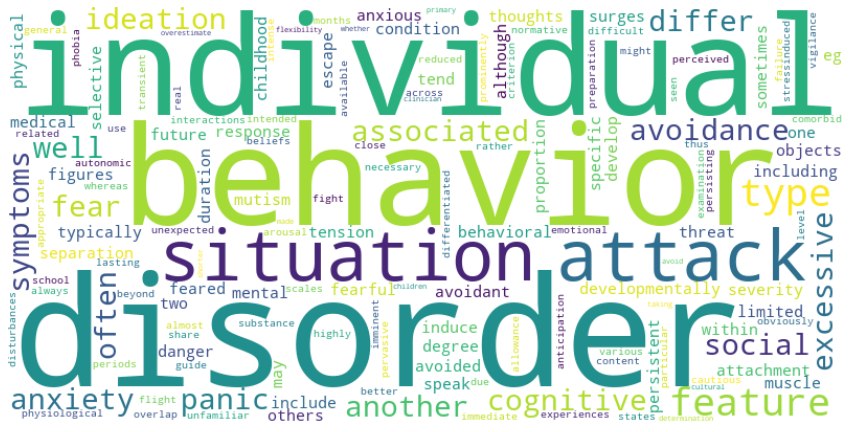

In [38]:
# Generate a word cloud image
terms = anx_freq_df[anx_freq_df.disorder == 'Anxiety Disorders'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])
wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)
# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

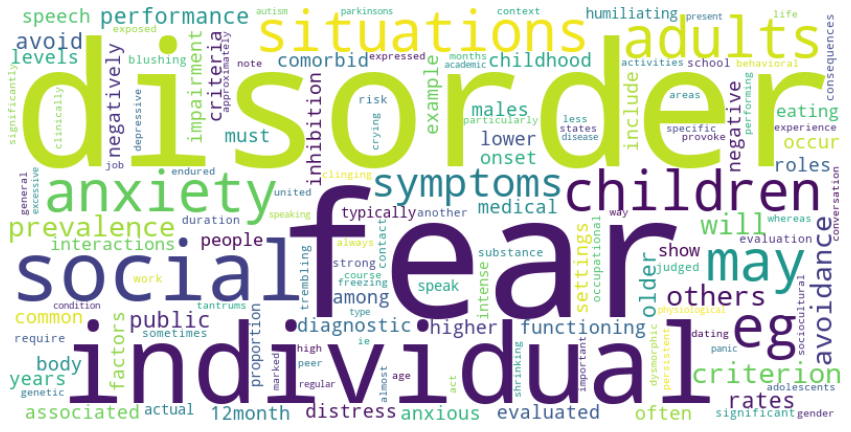

In [39]:
# Generate a word cloud image
terms = anx_freq_df[anx_freq_df.disorder == 'Social Anxiety Disorder (Social Phobia)'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])

wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)
# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

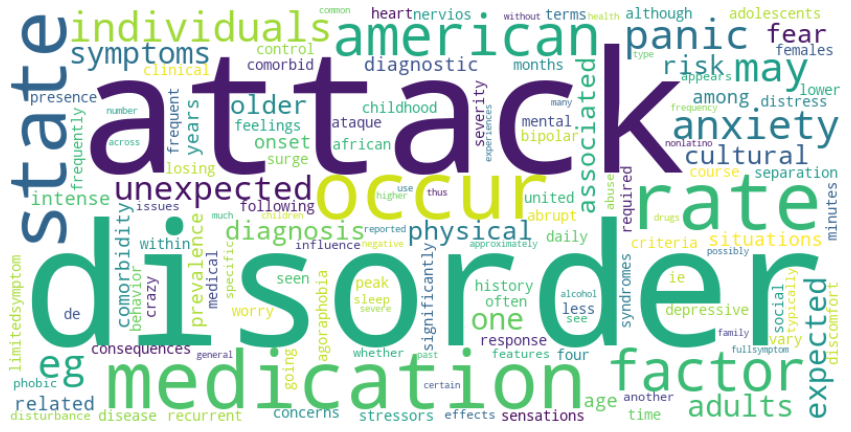

In [40]:
# Generate a word cloud image
terms = anx_freq_df[anx_freq_df.disorder == 'Panic Disorder'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])

wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)

# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
words = [[key,value] for key, value in \
         anx_freq_df[anx_freq_df.disorder == 'Panic Attack Specifier'].most_freq_terms.items()]
words

[[6,
  [('of', 72),
   ('panic', 62),
   ('the', 52),
   ('attacks', 45),
   ('and', 41),
   ('or', 38),
   ('a', 33),
   ('disorders', 28),
   ('in', 27),
   ('to', 27),
   ('are', 23),
   ('attack', 22),
   ('is', 22),
   ('for', 21),
   ('symptoms', 17),
   ('may', 17),
   ('as', 16),
   ('eg', 15),
   ('with', 15),
   ('disorder', 13),
   ('be', 12),
   ('individuals', 12),
   ('unexpected', 12),
   ('cultural', 12),
   ('not', 10),
   ('anxiety', 10),
   ('that', 10),
   ('which', 10),
   ('fear', 9),
   ('from', 9),
   ('associated', 9),
   ('minutes', 8),
   ('more', 8),
   ('than', 8),
   ('occur', 7),
   ('within', 7),
   ('an', 7),
   ('state', 7),
   ('expected', 7),
   ('prevalence', 7),
   ('mental', 6),
   ('can', 6),
   ('other', 6),
   ('use', 6),
   ('peak', 6),
   ('time', 6),
   ('four', 6),
   ('older', 6),
   ('depressive', 5),
   ('should', 5),
   ('criteria', 5),
   ('abrupt', 5),
   ('intense', 5),
   ('discomfort', 5),
   ('such', 5),
   ('ie', 5),
   ('by', 5)

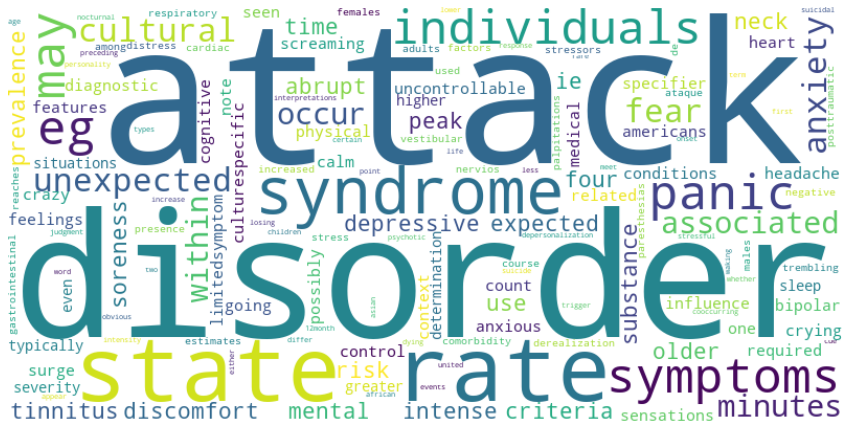

In [42]:
# Generate a word cloud image
terms = anx_freq_df[anx_freq_df.disorder == 'Panic Attack Specifier'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])

wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)
# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
words = [[key,value] for key, value in \
         anx_freq_df[anx_freq_df.disorder == 'Agoraphobia'].most_freq_terms.items()]
words

[[7,
  [('the', 82),
   ('of', 79),
   ('in', 60),
   ('or', 58),
   ('and', 48),
   ('to', 43),
   ('agoraphobia', 37),
   ('is', 31),
   ('anxiety', 29),
   ('as', 29),
   ('fear', 24),
   ('a', 23),
   ('are', 23),
   ('with', 22),
   ('disorder', 22),
   ('disorders', 18),
   ('eg', 17),
   ('situations', 16),
   ('be', 16),
   ('symptoms', 16),
   ('for', 16),
   ('panic', 16),
   ('avoidance', 15),
   ('being', 14),
   ('other', 14),
   ('individuals', 14),
   ('agoraphobic', 11),
   ('not', 10),
   ('such', 10),
   ('may', 10),
   ('that', 9),
   ('situation', 9),
   ('by', 8),
   ('criterion', 8),
   ('adults', 8),
   ('onset', 8),
   ('out', 7),
   ('depressive', 7),
   ('more', 6),
   ('fears', 6),
   ('feared', 6),
   ('older', 6),
   ('children', 6),
   ('most', 6),
   ('using', 5),
   ('individual', 5),
   ('might', 5),
   ('paniclike', 5),
   ('typically', 5),
   ('social', 5),
   ('if', 5),
   ('an', 5),
   ('from', 5),
   ('occur', 5),
   ('well', 5),
   ('risk', 5),
  

In [44]:
words = [value for key, value in \
         anx_freq_df[anx_freq_df.disorder == 'Agoraphobia'].diagnosis.items()]

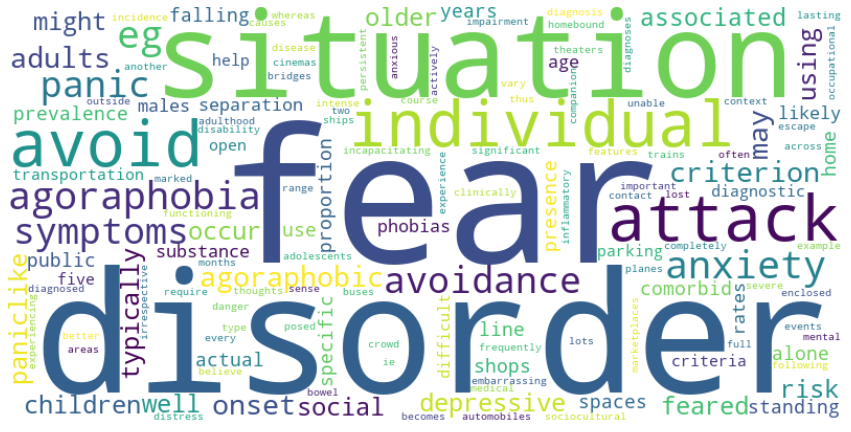

In [45]:
# Generate a word cloud image
terms = anx_freq_df[anx_freq_df.disorder == 'Agoraphobia'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])
wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)
# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [46]:
words = [[key,value] for key, value in \
         anx_freq_df[anx_freq_df.disorder == 'Generalized Anxiety Disorder'].most_freq_terms.items()]
words

[[8,
  [('the', 88),
   ('of', 61),
   ('disorder', 61),
   ('anxiety', 57),
   ('and', 57),
   ('in', 45),
   ('or', 41),
   ('to', 38),
   ('generalized', 35),
   ('with', 29),
   ('is', 28),
   ('are', 24),
   ('worry', 20),
   ('for', 20),
   ('about', 20),
   ('symptoms', 18),
   ('be', 17),
   ('more', 15),
   ('may', 15),
   ('excessive', 14),
   ('as', 13),
   ('other', 13),
   ('individuals', 13),
   ('disorders', 13),
   ('a', 12),
   ('associated', 11),
   ('worries', 11),
   ('at', 10),
   ('children', 10),
   ('their', 10),
   ('have', 10),
   ('than', 9),
   ('performance', 9),
   ('eg', 9),
   ('that', 9),
   ('social', 7),
   ('by', 7),
   ('from', 7),
   ('tend', 7),
   ('likely', 7),
   ('they', 7),
   ('comorbidity', 7),
   ('criteria', 6),
   ('not', 6),
   ('being', 6),
   ('adults', 6),
   ('life', 6),
   ('age', 6),
   ('events', 5),
   ('feeling', 5),
   ('on', 5),
   ('muscle', 5),
   ('physical', 5),
   ('impairment', 5),
   ('experience', 5),
   ('prevalence'

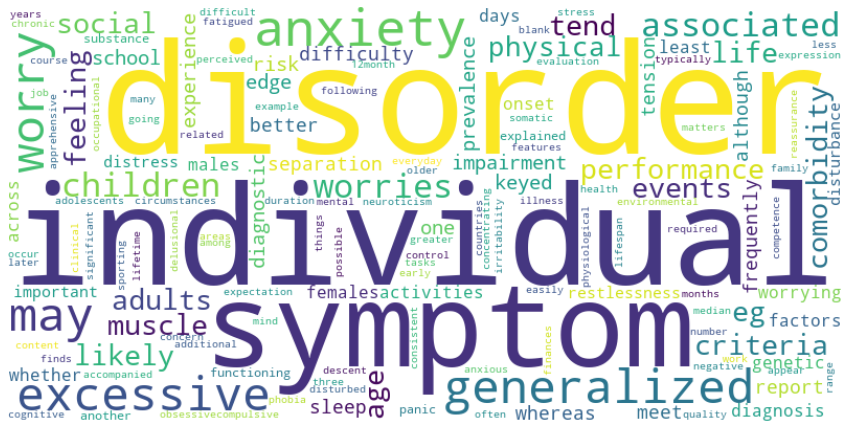

In [47]:
# Generate a word cloud image
terms = anx_freq_df[anx_freq_df.disorder == 'Generalized Anxiety Disorder'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])
wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)
# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
def get_terms_word_emb(list_terms, pathology_name):
    values_list = []

    for term in list_terms:
        try:
            vector = glove6b[term]  
            neighbors_glove6b = glove6b.most_similar([vector], topn=20, indexer=annoy_glove6b)
        except KeyError:
            print('Term "%s" not found in glove 6B' % (term))
            neighbors_glove6b = []

        try:
            vector = w2v_cbow_all_user[term]  
            neighbors_w2v_cbow_all_user = w2v_cbow_all_user.most_similar([vector], topn=20, 
                                                                         indexer=annoy_w2v_cbow_all_user)
        except KeyError:
            print('Term "%s" not found in w2v_cbow_all_user' % (term))
            neighbors_w2v_cbow_all_user = []

        try:
            vector = w2v_cbow_adad[term]  
            neighbors_w2v_cbow_adad = w2v_cbow_adad.most_similar([vector], topn=20, indexer=annoy_w2v_cbow_adad)
        except KeyError:
            print('Term "%s" not found in w2v_cbow_adad' % (term))
            neighbors_w2v_cbow_adad = []

        try:
            vector = glove_adad[term]  
            neighbors_glove_adad = glove_adad.most_similar([vector], topn=20, indexer=annoy_glove_adad)
        except KeyError:
            print('Term "%s" not found in glove_adad' % (term))
            neighbors_glove_adad = []
            
        try:
            vector = w2v_skip_all_user[term]  
            neighbors_w2v_skip_all_user = w2v_skip_all_user.most_similar([vector], topn=20,
                                                                         indexer=annoy_w2v_skip_all_user)
        except KeyError:
            print('Term "%s" not found in w2v_skip_all_user' % (term))
            neighbors_w2v_skip_all_user = []
            
        values_list.append([pathology_name, term, neighbors_glove6b, neighbors_w2v_cbow_all_user, 
                            neighbors_w2v_cbow_adad, neighbors_glove_adad, neighbors_w2v_skip_all_user])

    data_df = pd.DataFrame(values_list, columns =['pathology', 'term', 'glove6b', 'w2v_cbow_all_user', 
                                                  'w2v_cbow_adad', 'glove_adad', 'w2v_skip_all_user']) 
    
    return data_df

#### 1.3.1 Generates vector with main terms by pathology (visual inspection)

In [49]:
anxiety_dis = np.array(['anxious', 'agoraphobia', 'apprehensive', 'arousal', 'attacks', 'avoid', 'avoidance', 
                        'blank', 'clinging', 'control', 'crazy', 'crying', 'danger', 'depersonalization', 
                        'difficult', 'discomfort', 'distress', 'escape', 'excessive', 'failure', 
                        'falling', 'fear', 'feared', 'fearful', 'feelings', 'freezing', 'future', 'headache', 
                        'help', 'humiliating', 'impairment', 'incapacitating', 'intense', 'interactions', 
                        'irritability', 'losing', 'mind', 'mutism', 'nervios', 'neuroticism', 'palpitations', 
                        'panic', 'paresthesias', 'persistent', 'phobia', 'restlessness', 'risk', 
                        'screaming', 'shrinking', 'sleep', 'soreness', 'stress', 'tantrums', 'tension', 
                        'thoughts', 'trembling', 'uncontrollable', 'unexpected', 'worry'])

#### 1.3.2 Analyzes terms for Anxiety in Glove 6B, W2V CBOW, W2V Skipgram embeddings

In [50]:
anx_result_df = get_terms_word_emb(anxiety_dis, 'Anxiety Disorders')
anx_result_df.to_pickle(dn.PATH_PROJECT + "experiments/domain_vocabulary/anx_word_emb.df")
anx_result_df.head(10)

Term "mutism" not found in w2v_cbow_adad
Term "nervios" not found in glove 6B
Term "nervios" not found in w2v_cbow_all_user
Term "nervios" not found in w2v_cbow_adad
Term "nervios" not found in glove_adad
Term "nervios" not found in w2v_skip_all_user
Term "neuroticism" not found in w2v_cbow_adad
Term "paresthesias" not found in glove 6B
Term "paresthesias" not found in w2v_cbow_all_user
Term "paresthesias" not found in w2v_cbow_adad
Term "paresthesias" not found in w2v_skip_all_user


,pathology,term,glove6b,w2v_cbow_all_user,w2v_cbow_adad,glove_adad,w2v_skip_all_user
0,Anxiety Disorders,anxious,"[(anxious, 1.0), (eager, 0.6143440008163452), ...","[(anxious, 0.9998273665260058), (nervous, 0.67...","[(anxious, 1.0), (nervous, 0.6773909032344818)...","[(anxious, 1.0), (fewer, 0.9981648807879537), ...","[(minorit, 0.44371527433395386), (fluoxforce, ..."
1,Anxiety Disorders,agoraphobia,"[(agoraphobia, 1.0), (claustrophobia, 0.522158...","[(agoraphobia, 1.0), (depersonalization, 0.517...","[(agoraphobia, 1.0), (sharingan, 0.54738706350...","[(agoraphobia, 1.0), (lynchings, 0.89071897417...","[(p8z68v, 0.46977895498275757), (processorhttp..."
2,Anxiety Disorders,apprehensive,"[(apprehensive, 1.0), (leery, 0.58406022191047...","[(apprehensive, 1.0), (skeptical, 0.6319760680...","[(apprehensive, 1.0), (skeptical, 0.6445277333...","[(getintobedfree, 0.9685821309685707), (egregi...","[(bianco, 0.43921804428100586), (subjectso, 0...."
3,Anxiety Disorders,arousal,"[(arousal, 1.0), (physiological, 0.55027106404...","[(arousal, 1.0), (stimulation, 0.6125113964080...","[(arousal, 1.0), (stimulation, 0.5852984786033...","[(arousal, 1.0), (fundingtaxes:, 0.92780616134...","[(vacuumsealx1mylar, 0.46512842178344727), (va..."
4,Anxiety Disorders,attacks,"[(attacks, 1.0), (attack, 0.6949976682662964),...","[(attacks, 1.0), (attack, 0.6386306881904602),...","[(attacks, 1.0), (attack, 0.6359841525554657),...","[(attacks, 1.0), (terroristic, 0.9998779296875...","[(emrakul, 0.42439645528793335), (populists, 0..."
5,Anxiety Disorders,avoid,"[(avoid, 1.0), (avoiding, 0.7070868611335754),...","[(avoid, 1.0), (prevent, 0.5468047559261322), ...","[(avoid, 1.0), (prevent, 0.5426596403121948), ...","[(avoid, 1.0), (technique, 0.9882229035720229)...","[(visishtadvaita, 0.434567391872406), (waterfu..."
6,Anxiety Disorders,avoidance,"[(avoidance, 0.9998273665260058), (taxation, 0...","[(avoidance, 1.0), (escalation, 0.539952188730...","[(avoidance, 1.0), (apathy, 0.5524932742118835...","[(avoidance, 1.0), (dudehahahaha, 0.7053880989...","[(ockhams, 0.45491862297058105), (overclockabl..."
7,Anxiety Disorders,blank,"[(blank, 1.0), (empty, 0.46555638313293457), (...","[(blank, 1.0), (empty, 0.4542052149772644), (f...","[(blank, 1.0), (vertical, 0.4455831050872803),...","[(blank, 0.9998779296875), (canvasso, 0.980737...","[(katatonia, 0.4414170980453491), (usonly, 0.4..."
8,Anxiety Disorders,clinging,"[(clinging, 1.0), (clung, 0.6086921691894531),...","[(clinging, 1.0), (cling, 0.5969281792640686),...","[(clinging, 1.0), (cling, 0.5517049729824066),...","[(preteen, 0.9508879706263542), (facetimeironi...","[(philippa, 0.4461591839790344), (kingsley, 0...."
9,Anxiety Disorders,control,"[(control, 1.0), (controls, 0.6307211518287659...","[(control, 1.0), (controli, 0.554585725069046)...","[(control, 1.0), (defect, 0.49871641397476196)...","[(control, 1.0), (kicker:, 0.9455355703830719)...","[(bestwhat, 0.4246344566345215), (b150m, 0.422..."


In [51]:
anx_result_df[anx_result_df.term == 'anxious'].w2v_cbow_adad[0]

[('anxious', 1.0),
 ('nervous', 0.6773909032344818),
 ('paranoid', 0.6491542160511017),
 ('nauseous', 0.6283853352069855),
 ('selfconscious', 0.6251541376113892),
 ('irritable', 0.6214230358600616),
 ('uneasy', 0.6206002831459045),
 ('sleepy', 0.6147941648960114),
 ('stressed', 0.6066911518573761),
 ('frustrated', 0.6031316220760345),
 ('dizzy', 0.5921495258808136),
 ('insecure', 0.5863467454910278),
 ('nauseated', 0.5855545103549957),
 ('uncomfortable', 0.5831911861896515),
 ('agitated', 0.5785326659679413),
 ('embarrassed', 0.5703814625740051),
 ('dysphoric', 0.5690854489803314),
 ('angry', 0.567554771900177),
 ('lonely', 0.5652950406074524),
 ('upset', 0.5641515851020813)]

In [52]:
anx_result_df[anx_result_df.term == 'anxious'].glove6b[0]

[('anxious', 1.0),
 ('eager', 0.6143440008163452),
 ('worried', 0.6125668585300446),
 ('fearful', 0.6032894551753998),
 ('understandably', 0.5985301434993744),
 ('wary', 0.5870617032051086),
 ('nervous', 0.5810533165931702),
 ('frustrated', 0.5742678344249725),
 ('impatient', 0.5667023956775665),
 ('reassure', 0.5638873279094696),
 ('frightened', 0.5567012429237366),
 ('jittery', 0.5538085401058197),
 ('desperately', 0.5374681651592255),
 ('hesitant', 0.5373340547084808),
 ('excited', 0.5351840853691101),
 ('weary', 0.5350369215011597),
 ('tired', 0.5346816778182983),
 ('concerned', 0.5309315025806427),
 ('wanting', 0.5303855240345001),
 ('skeptical', 0.5302578210830688)]

### 1.4 Analyzes terms for Depression

#### 1.4.1 Generates list of most frequent terms based on DSM-5 diagnostic description for Depression

In [53]:
dep_freq_df = dep_df[:]
dep_freq_df.insert(dep_freq_df.columns.__len__(), 'most_freq_terms', 0)


dep_freq_df['most_freq_terms'] = dep_freq_df.apply(lambda row: 
                                                   sorted(Counter(row.diagnosis.lower().split(' '))\
                                                          .most_common(200), key=lambda item: item[1], 
                                                          reverse=True),
                                                   axis=1)

In [54]:
dep_freq_df[dep_freq_df.disorder == 'Depressive Disorder'].most_freq_terms[0]

[('of', 25),
 ('depressive', 21),
 ('disorder', 20),
 ('and', 19),
 ('the', 19),
 ('to', 12),
 ('in', 12),
 ('a', 10),
 ('disorders', 9),
 ('is', 9),
 ('major', 7),
 ('this', 7),
 ('for', 5),
 ('children', 5),
 ('with', 5),
 ('mood', 4),
 ('episode', 4),
 ('condition', 4),
 ('has', 4),
 ('or', 4),
 ('by', 4),
 ('that', 4),
 ('be', 4),
 ('persistent', 3),
 ('dysthymia', 3),
 ('medical', 3),
 ('dsmiv', 3),
 ('chapter', 3),
 ('from', 3),
 ('bipolar', 3),
 ('diagnosis', 3),
 ('episodes', 3),
 ('years', 3),
 ('on', 3),
 ('depression', 3),
 ('disruptive', 2),
 ('dysregulation', 2),
 ('premenstrual', 2),
 ('dysphoric', 2),
 ('substance/medicationinduced', 2),
 ('due', 2),
 ('another', 2),
 ('other', 2),
 ('been', 2),
 ('accompanied', 2),
 ('changes', 2),
 ('affect', 2),
 ('duration', 2),
 ('treatment', 2),
 ('new', 2),
 ('typically', 2),
 ('they', 2),
 ('it', 2),
 ('at', 2),
 ('least', 2),
 ('2', 2),
 ('although', 2),
 ('careful', 2),
 ('bereavement', 2),
 ('may', 2),
 ('induce', 2),
 ('not',

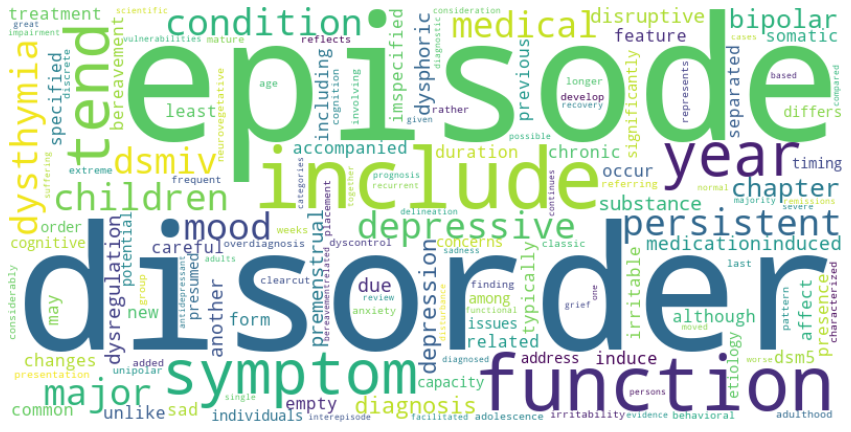

In [60]:
# Generate a word cloud image
terms = dep_freq_df[dep_freq_df.disorder == 'Depressive Disorder'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])
wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)
# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [61]:
words = [[key,value] for key, value in \
         dep_freq_df[dep_freq_df.disorder == 'Major Depressive Disorder'].most_freq_terms.items()]
words

[[2,
  [('the', 147),
   ('of', 144),
   ('or', 112),
   ('in', 99),
   ('and', 84),
   ('to', 84),
   ('a', 82),
   ('depressive', 56),
   ('is', 52),
   ('be', 43),
   ('with', 43),
   ('major', 43),
   ('may', 41),
   ('for', 39),
   ('individuals', 36),
   ('are', 34),
   ('symptoms', 32),
   ('disorder', 32),
   ('not', 27),
   ('that', 26),
   ('suicide', 21),
   ('more', 20),
   ('as', 20),
   ('by', 20),
   ('episode', 20),
   ('eg', 18),
   ('episodes', 17),
   ('have', 15),
   ('loss', 15),
   ('day', 15),
   ('criterion', 15),
   ('an', 15),
   ('risk', 15),
   ('nearly', 14),
   ('present', 13),
   ('at', 13),
   ('than', 13),
   ('such', 13),
   ('from', 12),
   ('mood', 12),
   ('individual', 12),
   ('depressed', 11),
   ('every', 11),
   ('who', 11),
   ('some', 11),
   ('most', 10),
   ('weight', 10),
   ('feelings', 10),
   ('thoughts', 10),
   ('other', 10),
   ('it', 10),
   ('features', 10),
   ('appear', 10),
   ('either', 9),
   ('medical', 9),
   ('others', 9),


In [62]:
words = [value for key, value in \
         dep_freq_df[dep_freq_df.disorder == 'Major Depressive Disorder'].diagnosis.items()]

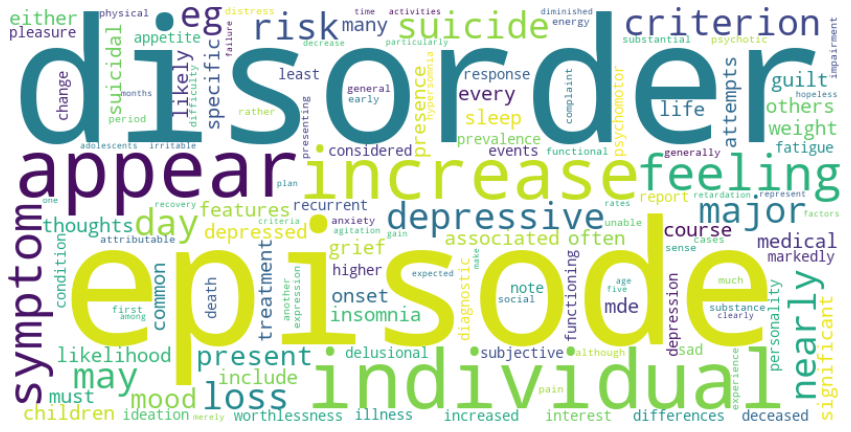

In [63]:
# Generate a word cloud image
terms = dep_freq_df[dep_freq_df.disorder == 'Major Depressive Disorder'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])
wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)
# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [64]:
words = [[key,value] for key, value in \
         dep_freq_df[dep_freq_df.disorder == 'Persistent Depressive Disorder (Dysthymia)'].most_freq_terms.items()]
words

[[3,
  [('depressive', 49),
   ('disorder', 47),
   ('of', 37),
   ('a', 35),
   ('the', 34),
   ('for', 28),
   ('major', 27),
   ('and', 25),
   ('or', 24),
   ('persistent', 23),
   ('with', 22),
   ('in', 21),
   ('episode', 16),
   ('at', 13),
   ('2', 12),
   ('years', 12),
   ('is', 12),
   ('criteria', 11),
   ('symptoms', 11),
   ('are', 11),
   ('to', 11),
   ('been', 10),
   ('have', 10),
   ('least', 9),
   ('p', 9),
   ('than', 8),
   ('not', 8),
   ('individuals', 8),
   ('onset', 8),
   ('as', 7),
   ('be', 7),
   ('if', 7),
   ('full', 7),
   ('features', 7),
   ('disorders', 7),
   ('chronic', 6),
   ('more', 6),
   ('met', 6),
   ('dysthymic', 5),
   ('mood', 5),
   ('1', 5),
   ('specify', 5),
   ('188', 5),
   ('early', 5),
   ('likely', 5),
   ('depressed', 4),
   ('by', 4),
   ('children', 4),
   ('adolescents', 4),
   ('year', 4),
   ('b', 4),
   ('during', 4),
   ('period', 4),
   ('has', 4),
   ('may', 4),
   ('there', 4),
   ('other', 4),
   ('eg', 4),
   ('th

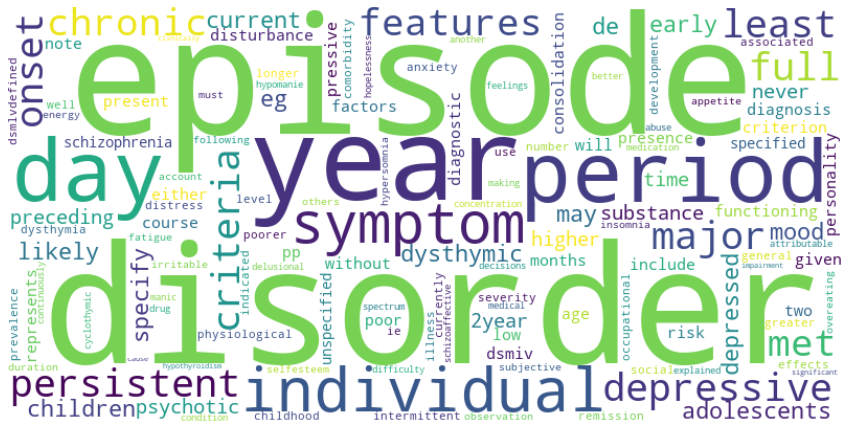

In [65]:
# Generate a word cloud image
terms = dep_freq_df[dep_freq_df.disorder == 'Persistent Depressive Disorder (Dysthymia)'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])
wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)
# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [66]:
words = [[key,value] for key, value in \
         dep_freq_df[dep_freq_df.disorder == 'Disruptive Mood Dysregulation Disorder'].most_freq_terms.items()]
words

[[1,
  [('disorder', 73),
   ('the', 65),
   ('of', 63),
   ('in', 49),
   ('and', 43),
   ('mood', 34),
   ('children', 32),
   ('with', 31),
   ('disruptive', 31),
   ('to', 30),
   ('or', 29),
   ('dysregulation', 29),
   ('a', 24),
   ('is', 22),
   ('be', 21),
   ('bipolar', 21),
   ('are', 20),
   ('for', 20),
   ('as', 19),
   ('irritability', 18),
   ('severe', 17),
   ('criteria', 15),
   ('not', 13),
   ('symptoms', 13),
   ('diagnosis', 13),
   ('that', 12),
   ('chronic', 12),
   ('have', 11),
   ('at', 11),
   ('should', 11),
   ('present', 9),
   ('such', 9),
   ('outbursts', 8),
   ('rates', 8),
   ('by', 7),
   ('has', 7),
   ('age', 7),
   ('which', 7),
   ('an', 7),
   ('depressive', 7),
   ('this', 7),
   ('both', 7),
   ('other', 7),
   ('presentations', 7),
   ('pediatric', 7),
   ('temper', 6),
   ('more', 6),
   ('been', 6),
   ('years', 6),
   ('meet', 6),
   ('only', 6),
   ('their', 6),
   ('also', 6),
   ('occur', 5),
   ('day', 5),
   ('least', 5),
   ('two'

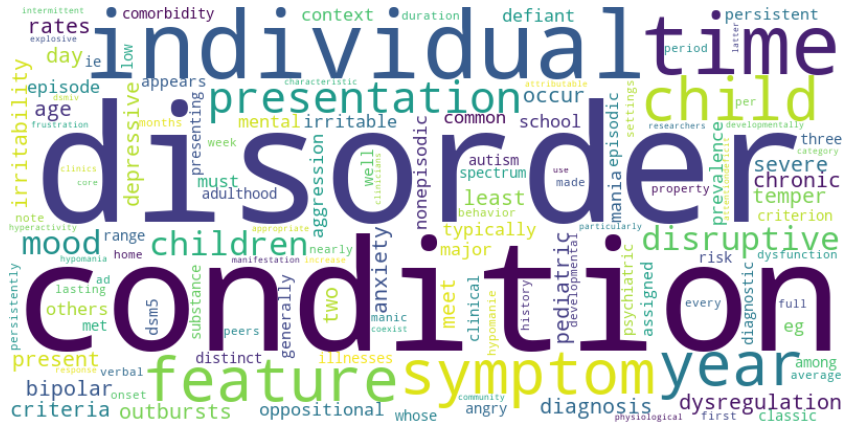

In [67]:
# Generate a word cloud image
terms = dep_freq_df[dep_freq_df.disorder == 'Disruptive Mood Dysregulation Disorder'].most_freq_terms.values[0]
word_lst = " ".join([term for term, metric_value in terms])
wordcloud = WordCloud(stopwords=None, background_color="white", width=800, height=400)\
            .generate(word_lst)
# Display the generated image, the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 1.4.1  Generates vector with main terms by pathology (visual inspection)

In [68]:
dep_dis = np.array(['aggression', 'angry', 'antidepressant', 'anxiety', 'appetite', 'behavioral', 'bereavement', 
                    'bereavementrelated', 'capacity', 'careful', 'change', 'concentration', 'concerns', 'death', 
                    'depressive', 'difficulty', 'dysthymia', 'disgust', 'displeasure', 'distress', 'disturbance', 
                    'dyscontrol', 'dysphoric', 'dysregulation', 'empty', 'energy', 'explosive', 'extreme', 
                    'facilitated', 'failure', 'fatigue', 'feelings', 'frustration', 'grief', 'guilt', 
                    'hopelessness', 'hypersomnia', 'impairment', 'insomnia', 'interest', 'irritable', 'loss', 
                    'mood', 'outbursts', 'overeating', 'pain', 'persistent', 'pleasure', 'retardation', 'sad', 
                    'selfesteem', 'sleep', 'suffering', 'suicide', 'thoughts', 'timing', 'vulnerabilities', 
                    'worse', 'worthlessness'])

#### 1.4.2 Analyzes terms for Depression in Glove 6B, W2V CBOW, W2V Skipgram embeddings

In [69]:
dep_result_df = get_terms_word_emb(dep_dis, 'Depressive Disorder')
dep_result_df.to_pickle(dn.PATH_PROJECT + "experiments/domain_vocabulary/dep_word_emb.df")
dep_result_df.head(10)

Term "antidepressant" not found in w2v_cbow_all_user
Term "antidepressant" not found in w2v_cbow_adad
Term "antidepressant" not found in glove_adad
Term "antidepressant" not found in w2v_skip_all_user
Term "anxiety" not found in w2v_cbow_all_user
Term "anxiety" not found in w2v_cbow_adad
Term "anxiety" not found in glove_adad
Term "anxiety" not found in w2v_skip_all_user
Term "bereavementrelated" not found in glove 6B
Term "bereavementrelated" not found in w2v_cbow_all_user
Term "bereavementrelated" not found in w2v_cbow_adad
Term "bereavementrelated" not found in glove_adad
Term "bereavementrelated" not found in w2v_skip_all_user
Term "depressive" not found in w2v_cbow_all_user
Term "depressive" not found in w2v_cbow_adad
Term "depressive" not found in glove_adad
Term "depressive" not found in w2v_skip_all_user
Term "dysthymia" not found in w2v_cbow_all_user
Term "dysthymia" not found in w2v_cbow_adad
Term "dysthymia" not found in glove_adad
Term "dysthymia" not found in w2v_skip_all_

,pathology,term,glove6b,w2v_cbow_all_user,w2v_cbow_adad,glove_adad,w2v_skip_all_user
0,Depressive Disorder,aggression,"[(aggression, 1.0), (provocation, 0.5267459154...","[(aggression, 0.999877929694776), (aggressiven...","[(aggression, 1.0), (aggressiveness, 0.5708963...","[(jumex, 0.9863936770707369), (drugs/dea, 0.98...","[(racism:, 0.4357680082321167), (evilalso, 0.4..."
1,Depressive Disorder,angry,"[(angry, 1.0), (enraged, 0.618416041135788), (...","[(angry, 1.0), (upset, 0.6971979141235352), (m...","[(angry, 1.0), (upset, 0.6811149716377258), (a...","[(angry, 1.0), (tangerinesim, 0.98377153463661...","[(mewling, 0.45380061864852905), (ooga, 0.4521..."
2,Depressive Disorder,antidepressant,"[(antidepressant, 0.9998779296875), (prozac, 0...",[],[],[],[]
3,Depressive Disorder,anxiety,"[(anxiety, 1.0), (nervousness, 0.5985841751098...",[],[],[],[]
4,Depressive Disorder,appetite,"[(appetite, 1.0), (appetites, 0.60889253020286...","[(appetite, 1.0), (libido, 0.6057699918746948)...","[(appetite, 1.0), (libido, 0.5972921252250671)...","[(appetite, 1.0), (splitsecond, 0.963907212018...","[(6c, 0.4325101971626282), (polygala, 0.431559..."
5,Depressive Disorder,behavioral,"[(behavioral, 1.0), (behavioural, 0.6709644198...","[(behavioral, 1.0), (behavioural, 0.7013038992...","[(behavioral, 0.9998273665260058), (behavioura...","[(behavioral, 1.0), (cofnitive, 0.992170352488...","[(dxf, 0.43824464082717896), (bookbinding, 0.4..."
6,Depressive Disorder,bereavement,"[(bereavement, 1.0), (grief, 0.465836942195892...","[(bereavement, 0.9998779296875), (fmla, 0.4983...","[(bereavement, 1.0), (spousal, 0.4660914540290...","[(helpironically, 1.0), (hunnam, 1.0), (indepe...","[(parnate, 0.48254287242889404), (totipotent, ..."
7,Depressive Disorder,bereavementrelated,[],[],[],[],[]
8,Depressive Disorder,capacity,"[(capacity, 0.999877929694776), (capacities, 0...","[(capacity, 0.9998273665260058), (capability, ...","[(capacity, 1.0), (capability, 0.5656479001045...","[(capacity, 1.0), (whr, 0.9371641352772713), (...","[(scirocco, 0.44253313541412354), (payware, 0...."
9,Depressive Disorder,careful,"[(careful, 1.0), (meticulous, 0.55969861149787...","[(careful, 1.0), (cautious, 0.6323968172073364...","[(careful, 1.0), (cautious, 0.6158905327320099...","[(careful, 1.0), (11/16, 0.9992088939761743), ...","[(lcarnitine, 0.43837976455688477), (preworkou..."


In [70]:
dep_result_df[dep_result_df.term == 'angry'].w2v_cbow_adad[1]

[('angry', 1.0),
 ('upset', 0.6811149716377258),
 ('annoyed', 0.6452509760856628),
 ('mad', 0.6445490121841431),
 ('frustrated', 0.624287873506546),
 ('resentful', 0.5687756240367889),
 ('anxious', 0.567554771900177),
 ('butthurt', 0.5616312026977539),
 ('irritated', 0.5616231262683868),
 ('agitated', 0.5587749481201172),
 ('furious', 0.5528770685195923),
 ('pissed', 0.5516481995582581),
 ('sad', 0.5509966611862183),
 ('impatient', 0.5505999028682709),
 ('pissy', 0.5473141968250275),
 ('embarrassed', 0.5469928085803986),
 ('bitter', 0.5457719564437866),
 ('defensive', 0.5405064821243286),
 ('cranky', 0.5385416150093079),
 ('paranoid', 0.5370926558971405)]

In [71]:
dep_result_df[dep_result_df.term == 'angry'].glove6b[1]

[('angry', 1.0),
 ('enraged', 0.618416041135788),
 ('furious', 0.6177931129932404),
 ('outraged', 0.5941185653209686),
 ('frustrated', 0.5826002657413483),
 ('angered', 0.572987288236618),
 ('provoked', 0.5432412326335907),
 ('annoyed', 0.5427790880203247),
 ('anger', 0.5327005684375763),
 ('agitated', 0.5304211676120758),
 ('protesters', 0.5270466506481171),
 ('protests', 0.5262647867202759),
 ('protest', 0.5252457559108734),
 ('prompting', 0.5243106186389923),
 ('frightened', 0.5242888033390045),
 ('impatient', 0.5233490467071533),
 ('unhappy', 0.5219808518886566),
 ('protesting', 0.5210904181003571),
 ('anxious', 0.5160232782363892),
 ('infuriated', 0.5130674242973328)]

In [72]:
# Common terms between anxiety and depression lists
np.intersect1d(anxiety_dis, dep_dis)

array(['distress', 'failure', 'feelings', 'impairment', 'persistent',
       'sleep', 'thoughts'], dtype='<U18')